# Experiments on pollution forecasting
## Sabrina Guastavino, guastavino@dima.unige.it

In [1]:
import os
import csv
import numpy as np
import random
import pandas
import pickle
import glob
import os.path
import sys
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

import time
import os.path
from sklearn.metrics import confusion_matrix

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
from utilities.utilities_forecasting import training_set_standardization,testing_set_standardization, div0, compute_cm_tss, \
compute_weight_cm_tss, optimize_threshold_skill_scores, optimize_threshold_skill_scores_weight_matrix,\
compute_cm_tss_threshold,predict,select_best_patience_on_val

## Data set

In [3]:
#read pollution dataset
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))#-i
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    print('agg',agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        print('')
    return agg
 
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

## normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)

# frame as supervised learning
n_in=1
n_out=1
reframed = series_to_supervised(values, n_in, n_out)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True) #1times
print('dataset')
reframed

agg        var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var6(t-1)  \
0            NaN        NaN        NaN        NaN        NaN         NaN   
1          129.0      -16.0       -4.0     1020.0        2.0    1.790000   
2          148.0      -15.0       -4.0     1020.0        2.0    2.680000   
3          159.0      -11.0       -5.0     1021.0        2.0    3.570000   
4          181.0       -7.0       -5.0     1022.0        2.0    5.360000   
...          ...        ...        ...        ...        ...         ...   
43795       10.0      -22.0       -2.0     1033.0        1.0  226.160004   
43796        8.0      -23.0       -2.0     1034.0        1.0  231.970001   
43797       10.0      -22.0       -3.0     1034.0        1.0  237.779999   
43798       10.0      -22.0       -3.0     1034.0        1.0  242.699997   
43799        8.0      -22.0       -4.0     1034.0        1.0  246.720001   

       var7(t-1)  var8(t-1)  var1(t)  var2(t)  var3(t)  var4(t)  var5(t)  \
0      

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.790000,0.0,0.0,148.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.680000,0.0,0.0,159.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.570000,0.0,0.0,181.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.360000,1.0,0.0,138.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.250000,2.0,0.0,109.0
...,...,...,...,...,...,...,...,...,...
43795,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0
43796,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0,10.0
43797,10.0,-22.0,-3.0,1034.0,1.0,237.779999,0.0,0.0,10.0
43798,10.0,-22.0,-3.0,1034.0,1.0,242.699997,0.0,0.0,8.0


## Training, validation and test sets

In [4]:
#***
#Experiments section 4 reference paper "Bad and good errors: value-weighted skill scores in deep ensemble learning"
#
# split into train and test sets
values = reframed.values
threshold_pol=450 #threshold which defines the level of high pollution values 

n_train_hours = 13104

n_val_hours = 4320
train_val = values[:n_train_hours+n_val_hours, :]
train = values[:n_train_hours, :]
val = values[n_train_hours:n_train_hours+n_val_hours, :]
# split into input and outputs
y_train = train[:, -1]>threshold_pol
y_val = val[:, -1]>threshold_pol
y_train_val = train_val[:, -1]>threshold_pol

X_train_val_std, mm ,dd= training_set_standardization(train_val[:, :-1])
X_train_std = X_train_val_std[:n_train_hours, :]
X_val_std=X_train_val_std[n_train_hours:n_train_hours+n_val_hours, :]

n_features=8

print('#samples in train+val:', len(y_train_val))
print('#yes in y_train_val:',len(np.where(y_train_val==1)[0]))
print('#samples in training: ', len(y_train))
print('#yes in y_train:',len(np.where(y_train==1)[0]))
print('#samples in validation: ', len(y_val))
print('# yes in y_val:',len(np.where(y_val==1)[0]))

n_test_hours=24*218
test_new2 = values[n_train_hours+n_val_hours:, :]
# split into input and outputs
X_test_std=testing_set_standardization(test_new2[:, :-1], mm, dd)
y_test2 = test_new2[:, -1]>threshold_pol 

print('#samples in test: ', len(y_test2))
print('#yes in y_test:', len(np.where(y_test2==1)[0]))
poll_test2=test_new2[:, -1]

#samples in train+val: 17424
#yes in y_train_val: 122
#samples in training:  13104
#yes in y_train: 107
#samples in validation:  4320
# yes in y_val: 15
#samples in test:  26375
#yes in y_test: 148


## Logistic Regression (LR)

In [5]:
# Logistic Regression (LR)
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train_val_std, y_train_val)

y_pred_test_lr=lr.predict(X_test_std)*1

# y_pred_test_lr is saved in prediction/y_pred_lr
#numpy.save('prediction/y_pred_lr.npy',y_pred_test_lr)

## Support Vector Machine (SVM)

In [6]:
# SVM
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.8)
svm.fit(X_train_val_std, y_train_val)

y_pred_test_svm=svm.predict(X_test_std)*1

# y_pred_test_svm is saved in prediction/y_pred_svm
#numpy.save('prediction/y_pred_svm.npy',y_pred_test_svm)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Fully connected neural network (NN)

In [7]:
# this is the model of NN used reference paper "Bad and good errors: value-weighted skill scores in deep ensemble learning"
#***
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics
model=models.Sequential()
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu',input_dim = 8))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

#model.fit(X_train_std, y_train,epochs=100,batch_size=512,validation_data=(X_val_std, y_val))
#model.save_weights('model_nn.hdf5')

model.load_weights('prediction/model_nn.hdf5')


# the threshold which converts probability outcomes in binary outcomes is chosen by optimizing the HSS on the training set
y_pred_train_nn=model.predict(X_train_std)
pred_prob_nn = y_pred_train_nn.reshape(1,len(y_pred_train_nn))
pred_prob_nn = pred_prob_nn[0]
#y_pred_val_nn=model.predict(X_val_std)
#pred_prob_val_nn = y_pred_val_nn.reshape(1,len(y_pred_val_nn))
#pred_prob_val_nn = pred_prob_val_nn[0]

threshold_nss, metrics_training, nss_vector, threshold_tss, threshold_hss, threshold_tss_hss, max_tss_hss = optimize_threshold_skill_scores(pred_prob_nn, y_train)
print(threshold_hss)


threshold_nn = threshold_hss

y_pred_test_nn_save=model.predict(X_test_std)
y_pred_test_nn_save=y_pred_test_nn_save.reshape(1,len(y_pred_test_nn_save))
y_pred_test_nn_save=y_pred_test_nn_save[0]

y_pred_test_nn=y_pred_test_nn_save>threshold_nn #0.077

# y_pred_test_nn_save is saved in results/y_pred_nn
#numpy.save('y_pred_nn.npy',y_pred_test_nn_save)

idx best nss= (array([89]),)
best NSS
confusion matrix
[[12947, 50], [18, 89]]
false alarm ratio       	 0.3597122302158273
probability of detection	 0.8317757009345794
accuracy                	 0.9948107448107448
hss                     	 0.7210027559318913
tss                     	 0.827928659309589
balance                 	 0.36
csi                 	 0.5668789808917197
idx best tss= (array([10]),)
best TSS
confusion matrix
[[12621, 376], [3, 104]]
false alarm ratio       	 0.7833333333333333
probability of detection	 0.9719626168224299
accuracy                	 0.9710775335775336
hss                     	 0.3456053026038669
tss                     	 0.9430328638025022
balance                 	 0.007978723404255319
csi                 	 0.2153209109730849
idx best hss= (array([98]),)
best HSS
confusion matrix
[[12963, 34], [23, 84]]
false alarm ratio       	 0.288135593220339
probability of detection	 0.7850467289719626
accuracy                	 0.9956501831501832
hss                

In [8]:
#***
# load the predictions on test test obtained by LR, SVM and NN
y_pred_test_lr = np.load('prediction/y_pred_lr.npy')
y_pred_test_svm = np.load('prediction/y_pred_svm.npy')
y_pred_test_nn_save = np.load('prediction/y_pred_nn.npy')
y_pred_test_nn=y_pred_test_nn_save>threshold_nn

## Results on a resticted test set

In [9]:

cm_test, tss_test, hss_test, csi_test = compute_cm_tss(y_test2[9000:9200], y_pred_test_lr[9000:9200])
print('Skill scores LR')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))


wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(y_test2[9000:9200], y_pred_test_lr[9000:9200])
print('Weighted Skill scores LR')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))

cm_test, tss_test, hss_test, csi_test = compute_cm_tss(y_test2[9000:9200], y_pred_test_svm[9000:9200])
print('Skill scores SVM')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))


wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(y_test2[9000:9200], y_pred_test_svm[9000:9200])
print('Weighted Skill scores SVM')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))


cm_test, tss_test, hss_test, csi_test = compute_cm_tss(y_test2[9000:9200], y_pred_test_nn[9000:9200])#_weight
print('Skill scores NN')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))


wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(y_test2[9000:9200], y_pred_test_nn[9000:9200])#_weight
print('Weighted Skill scores NN')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))

Skill scores LR
[[170   4]
 [  5  21]]
tss =  0.7847
hss =  0.7978
csi =  0.7000
Weighted Skill scores LR
[[170.    5. ]
 [  5.5  21. ]]
wtss =  0.7639
whss =  0.7700
wcsi =  0.6667
Skill scores SVM
[[173   1]
 [  6  20]]
tss =  0.7635
hss =  0.8315
csi =  0.7407
Weighted Skill scores SVM
[[173.   1.]
 [  7.  20.]]
wtss =  0.7350
whss =  0.8111
wcsi =  0.7143
Skill scores NN
[[162  12]
 [  4  22]]
tss =  0.7772
hss =  0.6873
csi =  0.5789
Weighted Skill scores NN
[[162.          14.16666667]
 [  3.16666667  22.        ]]
wtss =  0.7938
whss =  0.6685
wcsi =  0.5593


## Plot predictions

In [10]:
import datetime as dt

dates=dataset.index[n_train_hours+n_val_hours:]
tt = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates]

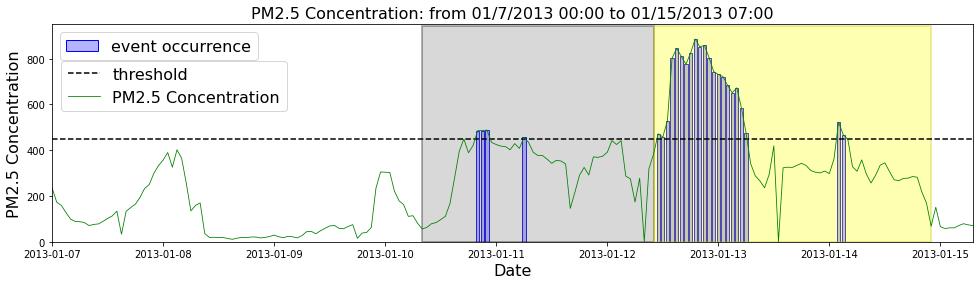

In [11]:
#FIGURE 2(a) reference paper 
import pandas as pd
folder_plot='plot_poll/'

tt_tot=tt[9000:9200]
poll_test_tot = poll_test2[9000:9200]
idx_event=np.where(poll_test_tot>threshold_pol)
tt_idx_event = []
for i in idx_event[0]:
    tt_idx_event.append(tt_tot[i])
fig = plt.figure()
ax = fig.gca()
plt.title('PM2.5 Concentration: from 01/7/2013 00:00 to 01/15/2013 07:00', fontsize=16)

plt.axhline(450,color='k',linestyle='--')

truth = ax.bar(tt_idx_event, poll_test_tot[idx_event[0]],facecolor='#b3b3ff', edgecolor='blue', width=0.029,label='event occurrence')
poll = ax.plot(tt_tot,poll_test2[9000:9200],color='green', linewidth=0.8) 

max_ylim=950
rectangle = plt.Rectangle((tt[9080],0), dt.timedelta(hours=50), max_ylim-8, linewidth=2.,edgecolor='k',facecolor='grey',alpha=0.3)
rectangle2 = plt.Rectangle((tt[9130],0), dt.timedelta(hours=60), max_ylim-8, linewidth=2.,edgecolor='y',facecolor='yellow',alpha=0.3)
ax.add_patch(rectangle)
ax.add_patch(rectangle2)
ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylim(0,max_ylim)
ax.set_xlim(pd.Timestamp(2013, 1, 7, 0),pd.Timestamp(2013, 1, 15, 7))#pd.Timestamp('2013-01-07'), pd.Timestamp('2013-1-16'))
first_legend=plt.legend(handles=[truth],loc='upper left', fontsize=16)
ax.add_artist(first_legend)
ax.legend(['threshold','PM2.5 Concentration'],loc=(0.01,0.6),fontsize=16) #,'Event > 50 mm/h and no lamps'
fig.set_size_inches(16.5,4.)
#plt.savefig(folder_plot+"poll_boxes_2013_01_7_to_2013_01_15_review.png")


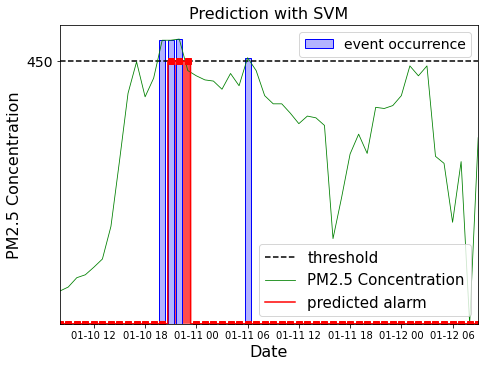

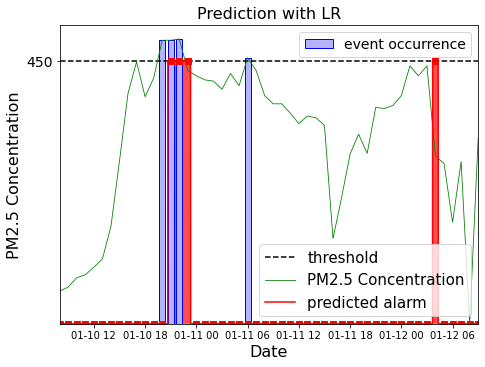

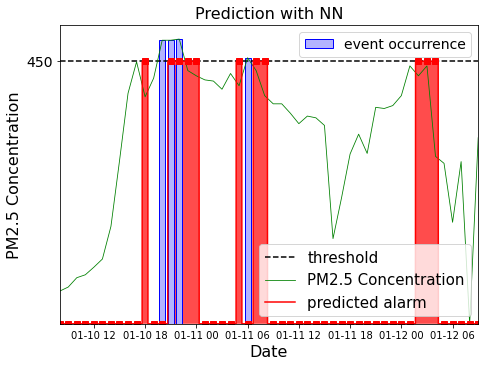

In [12]:
#Figures paper 2(b),(c),(d)
from utilities.utilities_forecasting import make_box_figure


folder_plot='plot_poll/'

tt1=tt[9080:9130]
poll_test_box1=poll_test2[9080:9130]
idx_event_box1=np.where(poll_test_box1>threshold_pol)

# SVM
y_pred_test_box1=y_pred_test_svm[9080:9130]

tt1_new_arrange, y_pred_test_box1_new = make_box_figure(y_pred_test_box1,tt1)

tt1_idx_event = []
for i in idx_event_box1[0]:
    tt1_idx_event.append(tt1[i])
    
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction with SVM', fontsize=16)

plt.axhline(450,color='k',linestyle='--')


truth = ax.bar(tt1_idx_event, poll_test_box1[idx_event_box1], facecolor='#b3b3ff', edgecolor='blue', width=0.029,label='event occurrence')
poll = ax.plot(tt1,poll_test2[9080:9130],color='green', linewidth=0.8) 
pred_plot = ax.plot(tt1_new_arrange, 450*y_pred_test_box1_new)

pred_plot_dots = ax.plot(tt1, 450*(y_pred_test_svm[9080:9130]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_svm[9080:9130]), facecolor='red', interpolate=True,alpha=0.7)

plt.setp(pred_plot_dots, linewidth=50, color='r')
ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=16)
ax.set_xlabel('Date', fontsize=16)

ax.set_xlim(pd.Timestamp(2013, 1, 10, 8),pd.Timestamp(2013, 1, 12, 9))#pd.Timestamp('2013-01-07'), pd.Timestamp('2013-1-16'))
ax.set_yticks([450])
ax.set_yticklabels(['450'], fontsize=14)

first_legend=plt.legend(handles=[truth],loc='upper right', fontsize=14)
ax.add_artist(first_legend)

ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc='lower right',fontsize=15) 
fig.set_size_inches(7.5, 5.5)
#plt.savefig(folder_plot+"pred_poll_svm_zoom1_review.png")


# LR
y_pred_test_box1=y_pred_test_lr[9080:9130]
tt1_new_arrange, y_pred_test_box1_new = make_box_figure(y_pred_test_box1,tt1)

tt1_idx_event = []
for i in idx_event_box1[0]:
    tt1_idx_event.append(tt1[i])
    
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction with LR', fontsize=16)

plt.axhline(450,color='k',linestyle='--')


truth = ax.bar(tt1_idx_event, poll_test_box1[idx_event_box1], facecolor='#b3b3ff', edgecolor='blue', width=0.029,label='event occurrence')
poll = ax.plot(tt[9080:9130],poll_test2[9080:9130],color='green', linewidth=0.8) 
pred_plot = ax.plot(tt1_new_arrange, 450*(y_pred_test_box1_new))

pred_plot_dots = ax.plot(tt1, 450*(y_pred_test_lr[9080:9130]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_box1_new), facecolor='red', interpolate=True,alpha=0.7)

plt.setp(pred_plot_dots, linewidth=50, color='r')
ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
#ax.set_yscale('log')
ax.set_xlim(pd.Timestamp(2013, 1, 10, 8),pd.Timestamp(2013, 1, 12, 9))
ax.set_yticks([450])
ax.set_yticklabels(['450'], fontsize=14)


first_legend=plt.legend(handles=[truth],loc='upper right', fontsize=14)
ax.add_artist(first_legend)

ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc='lower right',fontsize=15) 
fig.set_size_inches(7.5, 5.5)
#plt.savefig(folder_plot+"pred_poll_lr_zoom1_review.png")

#NN

y_pred_test_box1=y_pred_test_nn[9080:9130]

tt1_new_arrange, y_pred_test_box1_new = make_box_figure(y_pred_test_box1,tt1)

tt1_idx_event = []
for i in idx_event_box1[0]:
    tt1_idx_event.append(tt1[i])
    
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction with NN', fontsize=16)
plt.axhline(450,color='k',linestyle='--')

truth = ax.bar(tt1_idx_event, poll_test_box1[idx_event_box1], facecolor='#b3b3ff', edgecolor='blue', width=0.029,label='event occurrence')
poll = ax.plot(tt[9080:9130],poll_test2[9080:9130],color='green', linewidth=0.8)
pred_plot = ax.plot(tt1_new_arrange, 450*(y_pred_test_box1_new))
pred_plot_dots = ax.plot(tt1, 450*(y_pred_test_nn[9080:9130]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_box1_new), facecolor='red', interpolate=True,alpha=0.7)
plt.setp(pred_plot_dots, linewidth=50, color='r')
ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_xlim(pd.Timestamp(2013, 1, 10, 8),pd.Timestamp(2013, 1, 12, 9))#pd.Timestamp('2013-01-07'), pd.Timestamp('2013-1-16'))
ax.set_yticks([450])
ax.set_yticklabels(['450'], fontsize=14)
first_legend=plt.legend(handles=[truth],loc='upper right', fontsize=14)
ax.add_artist(first_legend)
ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc='lower right',fontsize=15) 
fig.set_size_inches(7.5, 5.5)
#plt.savefig(folder_plot+"pred_poll_nn_zoom1_review.png")



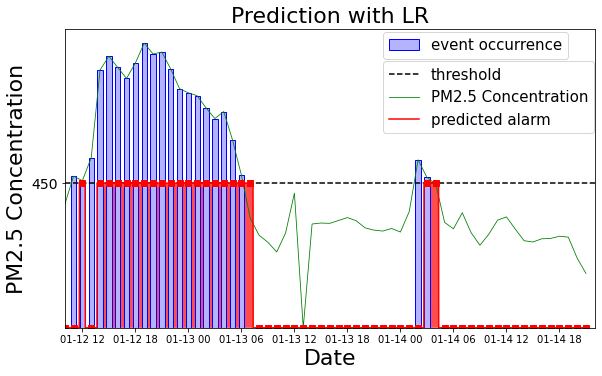

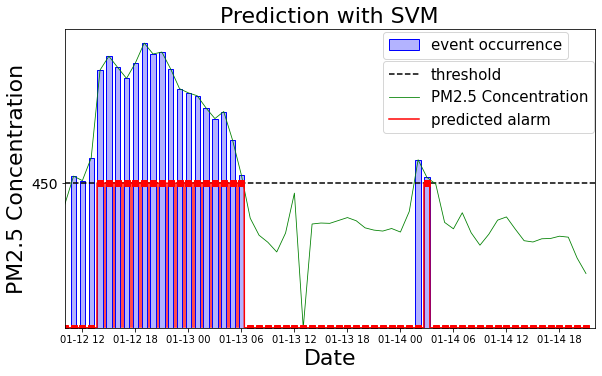

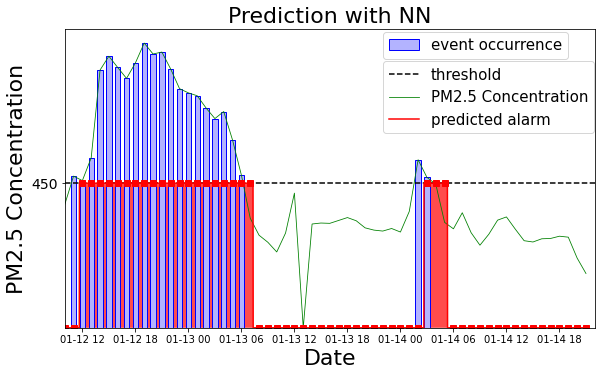

In [13]:
#Figures paper 2(e),(f),(g)

folder_plot='plot_poll/'

tt1=tt[9130:9190]
poll_test_box1=poll_test2[9130:9190]
idx_event_box1=np.where(poll_test_box1>threshold_pol)

#LR
y_pred_test_box1=y_pred_test_lr[9130:9190]
tt1_new_arrange, y_pred_test_box1_new = make_box_figure(y_pred_test_box1,tt1)

tt1_idx_event = []
for i in idx_event_box1[0]:
    tt1_idx_event.append(tt1[i])
    
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction with LR', fontsize=22)

plt.axhline(450,color='k',linestyle='--')

truth = ax.bar(tt1_idx_event, poll_test_box1[idx_event_box1], facecolor='#b3b3ff', edgecolor='blue', width=0.025,label='event occurrence')
poll = ax.plot(tt[9130:9190],poll_test2[9130:9190],color='green', linewidth=0.8) 
pred_plot = ax.plot(tt1_new_arrange, 450*(y_pred_test_box1_new))

pred_plot_dots = ax.plot(tt1, 450*(y_pred_test_lr[9130:9190]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_box1_new), facecolor='red', interpolate=True,alpha=0.7)

plt.setp(pred_plot_dots, linewidth=50, color='r')

ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=22)
ax.set_xlabel('Date', fontsize=22)
ax.set_xlim(pd.Timestamp(2013,1,12, 10),pd.Timestamp(2013, 1, 14, 22))
ax.set_yticks([450])
ax.set_yticklabels(['450'], fontsize=14)
first_legend=plt.legend(handles=[truth],loc=(0.6, 0.9), fontsize=15)
ax.add_artist(first_legend)
ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc=(0.6, 0.65),fontsize=15) 
fig.set_size_inches(9.5, 5.5)
#plt.savefig(folder_plot+"pred_poll_lr_zoom2_review.png")


#SVM
y_pred_test_box1=y_pred_test_svm[9130:9190]

tt1_new_arrange, y_pred_test_box1_new = make_box_figure(y_pred_test_box1,tt1)

tt1_idx_event = []
for i in idx_event_box1[0]:
    tt1_idx_event.append(tt1[i])
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction with SVM', fontsize=22)
plt.axhline(450,color='k',linestyle='--')

truth = ax.bar(tt1_idx_event, poll_test_box1[idx_event_box1], facecolor='#b3b3ff', edgecolor='blue', width=0.025,label='event occurrence')
poll = ax.plot(tt[9130:9190],poll_test2[9130:9190],color='green', linewidth=0.8) 
pred_plot = ax.plot(tt1_new_arrange, 450*(y_pred_test_box1_new))
pred_plot_dots = ax.plot(tt1, 450*(y_pred_test_svm[9130:9190]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_box1_new), facecolor='red', interpolate=True,alpha=0.7)

plt.setp(pred_plot_dots, linewidth=50, color='r')

ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=22)
ax.set_xlabel('Date', fontsize=22)
ax.set_xlim(pd.Timestamp(2013,1,12, 10),pd.Timestamp(2013, 1, 14, 22))
ax.set_yticks([450])
ax.set_yticklabels(['450'], fontsize=14)

first_legend=plt.legend(handles=[truth],loc=(0.6, 0.9), fontsize=15)
ax.add_artist(first_legend)
ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc=(0.6, 0.65),fontsize=15) 
fig.set_size_inches(9.5, 5.5)
#plt.savefig(folder_plot+"pred_poll_svm_zoom2_review.png")


#NN
y_pred_test_box1=y_pred_test_nn[9130:9190]
tt1_new_arrange, y_pred_test_box1_new = make_box_figure(y_pred_test_box1,tt1)

tt1_idx_event = []
for i in idx_event_box1[0]:
    tt1_idx_event.append(tt1[i])
    
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction with NN', fontsize=22)
plt.axhline(450,color='k',linestyle='--')

truth = ax.bar(tt1_idx_event, poll_test_box1[idx_event_box1], facecolor='#b3b3ff', edgecolor='blue', width=0.025,label='event occurrence')
poll = ax.plot(tt[9130:9190],poll_test2[9130:9190],color='green', linewidth=0.8) 
pred_plot = ax.plot(tt1_new_arrange, 450*(y_pred_test_box1_new))

pred_plot_dots = ax.plot(tt1, 450*(y_pred_test_nn[9130:9190]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_box1_new), facecolor='red', interpolate=True,alpha=0.7)

plt.setp(pred_plot_dots, linewidth=50, color='r')

ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=22)
ax.set_xlabel('Date', fontsize=22)
ax.set_xlim(pd.Timestamp(2013,1,12, 10),pd.Timestamp(2013, 1, 14, 22))
ax.set_yticks([450])
ax.set_yticklabels(['450'], fontsize=14)
first_legend=plt.legend(handles=[truth],loc=(0.6, 0.9), fontsize=15)
ax.add_artist(first_legend)
ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc=(0.6, 0.65),fontsize=15) 
fig.set_size_inches(9.5, 5.5)
#plt.savefig(folder_plot+"pred_poll_nn_zoom2_review.png")





# Deep ensemble classifiers
## Pollution forecasting

In [14]:
import keras
import numpy
from keras.layers import Dense, Flatten
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from keras.models import Model
from keras.models import Input

from sklearn.metrics import confusion_matrix

from keras import backend as K
import tensorflow as tf


from collections import deque
import sys
import matplotlib.pyplot as plt

## Training and validation sets

In [15]:
# Dataset pollution
values = reframed.values
threshold_pol=450

n_train_hours = 13104

n_val_hours = 4320
train = values[:n_train_hours, :]
test = values[n_train_hours:n_train_hours+n_val_hours, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]>threshold_pol
val_X, val_y = test[:, :-1], test[:, -1]>threshold_pol

## reshape input to be 3D [samples, timesteps, features]
n_features=8
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
val_X = val_X.reshape((val_X.shape[0], n_in, n_features))

print('#samples training: ', len(train_y))
print('#yes in training: ', len(np.where(train_y==1)[0]))
print('#samples validation: ', len(val_y))
print('#yes in validation: ', len(np.where(val_y==1)[0]))


#samples training:  13104
#yes in training:  107
#samples validation:  4320
#yes in validation:  15


## Long Short Term Memory (LSTM) model

In [16]:
run = False
save = False

if run == True:

    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.summary()
    
    if save == True:
        #save models of all epochs: they are saved in prediction/checkpoints
        checkpointer = ModelCheckpoint(
                filepath=os.path.join('prediction', 'checkpoints', 'lstm_pred_poll_8features_train_13104_val_4320_poll_450_epoch' \
                    '.{epoch:03d}-{val_loss:.3f}.hdf5'), 
                verbose=1,
                save_best_only=False)

    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(val_X, val_y), 
                        callbacks=[checkpointer],verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

## Test set

In [17]:
n_test_hours=24*218
test_new2 = values[n_train_hours+n_val_hours:, :]
# split into input and outputs
Xtest2, ytest2 = test_new2[:, :-1], test_new2[:, -1]>threshold_pol

Xtest2=Xtest2.reshape((Xtest2.shape[0], n_in, n_features))
print('#samples in test: ', len(ytest2))
print('#yes in test: ', len(np.where(ytest2==1)[0]))
poll_test2=test_new2[:, -1]

#samples in test:  26375
#yes in test:  148


## Optimization procedure to select optimal thresholds along epochs

In [18]:
# Compute the optimal thresholds which convert probability outcomes in 0/1:
# the thresholds are computed by optimizing TSS and wTSS on the training set

folder = 'prediction/checkpoints/'

#read models
list_epochs = sorted(glob.glob(folder+'lstm_1times_pred_poll_8features_train_13104_val_4320_poll_450_epoch*.hdf5'))
file_name = 'lstm_1times_pred_poll_8features_train_13104_val_4320_poll_450.npy'

if run == True:
    y_train=train_y
    y_val=val_y


    threshold_opt_tss=[]


    tss_train_dict_opt_tss=[]
    tss_val_dict_opt_tss=[]

    tss_train_dict_opt_tss_weight=[]
    tss_val_dict_opt_tss_weight=[]


    j=0

    for file in list_epochs:
        print(file)
        model = load_model(file,compile=False)
        pred_train = model.predict(train_X)
        pred_val = model.predict(val_X)
        pred_prob = pred_train.reshape(1,len(pred_train))
        pred_prob = pred_prob[0]
        pred_prob_val = pred_val.reshape(1,len(pred_val))
        pred_prob_val = pred_prob_val[0]

        #OPTIMIZE wTSS 
        threshold_nss_weight, metrics_training_weight, nss_vector_weight, threshold_tss_weight, threshold_hss_weight, threshold_tss_hss_weight, max_tss_hss_weight = optimize_threshold_skill_scores_weight_matrix(pred_prob, y_train)


        threshold_opt_tss_weight.append(threshold_tss_weight)


        #OPTIMIZE TSS
        threshold_nss, metrics_training, nss_vector, threshold_tss, threshold_hss, threshold_tss_hss, max_tss_hss = optimize_threshold_skill_scores(pred_prob, y_train)


        threshold_opt_tss.append(threshold_tss)



        j = j + 1



        #best tss
        cm, tss, hss, csi  = compute_cm_tss_threshold(y_train, pred_prob,threshold_tss)
        tss_train_dict_opt_tss.append(tss)
        cm_val, tss_val, hss_val, csi_val = compute_cm_tss_threshold(y_val, pred_prob_val,threshold_tss)
        tss_val_dict_opt_tss.append(tss_val)
        print ('threshold best tss                 \t', threshold_tss)



        #best wtss
        cm, tss, hss, csi  = compute_weight_cm_tss_threshold(y_train, pred_prob,threshold_tss_weight)
        tss_train_dict_opt_tss_weight.append(tss)
        hss_train_dict_opt_tss_weight.append(hss)
        cm_val, tss_val, hss_val, csi_val = compute_weight_cm_tss_threshold(y_val, pred_prob_val,threshold_tss_weight)
        tss_val_dict_opt_tss_weight.append(tss_val)
        hss_val_dict_opt_tss_weight.append(hss_val)
        print ('threshold best wtss                 \t', threshold_tss_weight)





    #save variables
    path_to_save = 'utilities/save_variables/'
    ###########
    file_tss_val_dict_tss = path_to_save+ 'tss_val_optimize_TSS_'+file_name
    file_tss_train_dict_tss = path_to_save+ 'tss_train_optimize_TSS_'+file_name
    file_threshold_dict_tss = path_to_save+ 'thresholds_val_optimize_TSS_'+file_name
    
    ###########
    file_tss_val_dict_tss_weight = path_to_save+ 'tss_val_weight_optimize_TSS_'+file_name
    file_tss_train_dict_tss_weight = path_to_save+ 'tss_train_weight_optimize_TSS_'+file_name
    file_threshold_dict_tss_weight = path_to_save+ 'thresholds_val_weight_optimize_TSS_'+file_name
    
    if save == True:
        numpy.save(file_tss_val_dict_tss, tss_val_dict_opt_tss)
        numpy.save(file_tss_train_dict_tss, tss_train_dict_opt_tss)
        numpy.save(file_threshold_dict_tss, threshold_opt_tss)
        
        numpy.save(file_tss_val_dict_tss_weight, tss_val_dict_opt_tss_weight)
        numpy.save(file_tss_train_dict_tss_weight, tss_train_dict_opt_tss_weight)
        numpy.save(file_threshold_dict_tss_weight, threshold_opt_tss_weight)


In [19]:
path_to_save = 'utilities/save_variables/'
file_name = 'lstm_1times_pred_poll_8features_train_13104_val_4320_poll_450.npy'

file_tss_val_dict_opt_tss = path_to_save+'tss_val_optimize_TSS_'+file_name
file_wtss_val_dict_opt_tss_weight = path_to_save+'tss_val_weight_optimize_TSS_'+file_name
file_tss_train_dict_opt_tss = path_to_save+'tss_train_optimize_TSS_'+file_name
file_wtss_train_dict_opt_tss_weight = path_to_save+'tss_train_weight_optimize_TSS_'+file_name
tss_val_dict_opt_tss = np.load(file_tss_val_dict_opt_tss)
tss_val_dict_opt_tss_weight = np.load(file_wtss_val_dict_opt_tss_weight)
tss_train_dict_opt_tss = np.load(file_tss_train_dict_opt_tss)
tss_train_dict_opt_tss_weight = np.load(file_wtss_train_dict_opt_tss_weight)
threshold_opt_tss=np.load(path_to_save+'thresholds_val_optimize_TSS_'+file_name)
threshold_opt_tss_weight=np.load(path_to_save+'thresholds_val_weight_optimize_TSS_'+file_name)

## Plot TSS and wTSS along epochs

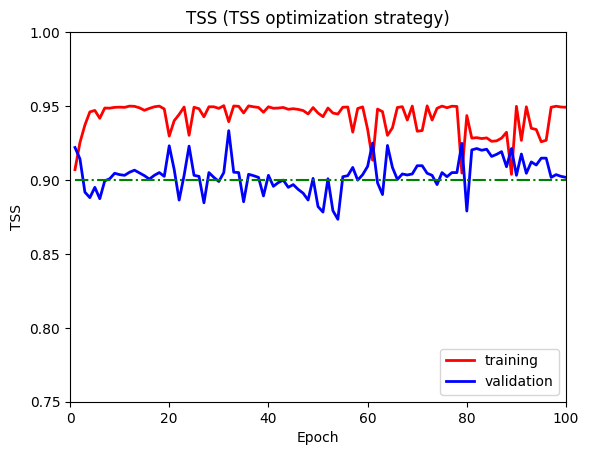

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('default')
fig = plt.figure()
ax = fig.gca()
plt.title("TSS (TSS optimization strategy)")
plot_train = ax.plot(np.arange(1,len(tss_train_dict_opt_tss)+1), tss_train_dict_opt_tss, label="TSS training",color='red')

plot_val = ax.plot(np.arange(1, len(tss_val_dict_opt_tss)+1), tss_val_dict_opt_tss, label="TSS validation",color='blue')
plot_1 = ax.plot(np.arange(1, len(tss_val_dict_opt_tss)+1), np.zeros(len(tss_val_dict_opt_tss))+0.9,'-.',color='green')

plt.setp(plot_train, linewidth=2, color='r')
plt.setp(plot_val, linewidth=2, color='b')

ax.set_ylabel('TSS')
ax.set_xlabel('Epoch')
ax.set_xlim(0,len(tss_train_dict_opt_tss))
ax.set_ylim(0.75,1.)
ax.legend(['training','validation'], loc="lower right") 



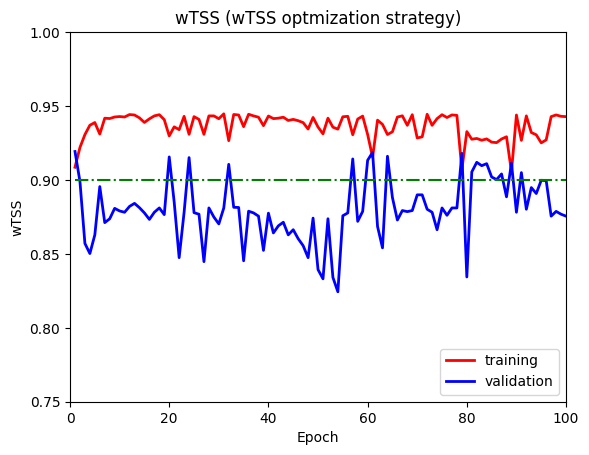

In [21]:

mpl.style.use('default')
fig = plt.figure()
ax = fig.gca()
plt.title("wTSS (wTSS optmization strategy)")
plot_train = ax.plot(np.arange(1,len(tss_train_dict_opt_tss_weight)+1), tss_train_dict_opt_tss_weight, label="TSS training",color='red')

plot_val = ax.plot(np.arange(1, len(tss_val_dict_opt_tss_weight)+1), tss_val_dict_opt_tss_weight, label="TSS validation",color='blue')
plot_1 = ax.plot(np.arange(1, len(tss_val_dict_opt_tss_weight)+1), np.zeros(len(tss_val_dict_opt_tss_weight))+0.9,'-.',color='green')

plt.setp(plot_train, linewidth=2, color='r')
plt.setp(plot_val, linewidth=2, color='b')
ax.set_ylabel('wTSS')
ax.set_xlabel('Epoch')
ax.set_xlim(0,len(tss_train_dict_opt_tss))
ax.set_ylim(0.75,1.)
ax.legend(['training','validation'], loc="lower right") 


## Predict on test set (using ensemble procedure based on the TSS and wTSS optimization strategy)

In [22]:

folder = 'prediction/checkpoints/'

#load variables
list_epochs = sorted(glob.glob(folder+'lstm_1times_pred_poll_8features_train_13104_val_4320_poll_450_epoch*.hdf5'))


pred_0_1_test_list=[]
pred_0_1_weight_test_list=[]


idx_weight=np.where(np.array(tss_val_dict_opt_tss_weight)>0.9)
idx_weight=idx_weight[0]

idx=np.where(np.array(tss_val_dict_opt_tss)>0.9)
idx=idx[0]


for i in idx:
    file=list_epochs[i]
    #print(file)
    model = load_model(file,compile=False)
    pred_test = model.predict(Xtest2)
    pred_prob_test = pred_test.reshape(1,len(pred_test))
    pred_prob_test = pred_prob_test[0]
    
    pred_0_1_test = pred_prob_test > threshold_opt_tss[i]
    pred_0_1_test_list.append(pred_0_1_test)

    
for i in idx_weight:
    file=list_epochs[i]
    #print(file)
    model = load_model(file,compile=False)
    pred_test = model.predict(Xtest2)
    pred_prob_test = pred_test.reshape(1,len(pred_test))
    pred_prob_test = pred_prob_test[0]
    
    pred_0_1_test_weight = pred_prob_test > threshold_opt_tss_weight[i]
    pred_0_1_weight_test_list.append(pred_0_1_test_weight)

pred_0_1_arr=numpy.array(pred_0_1_test_list)*1
pred_0_1_weight_arr=numpy.array(pred_0_1_weight_test_list)*1

pred_median_pred_0_1=numpy.median(pred_0_1_arr,axis=0)
pred_median_pred_0_1_weight=numpy.median(pred_0_1_weight_arr,axis=0)

# if 
idx_to_discard=numpy.where(pred_median_pred_0_1==0.5)[0]
pred_median_pred_0_1[idx_to_discard]=1

idx_to_discard_weight=numpy.where(pred_median_pred_0_1_weight==0.5)[0]
pred_median_pred_0_1_weight[idx_to_discard_weight]=1

## Results on test set

In [23]:
#Results on test set
cm_test, tss_test, hss_test, csi_test = compute_cm_tss(ytest2, pred_median_pred_0_1_weight)
print('Skill scores (otimization weighted tss)')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))
cm_test, tss_test, hss_test, csi_test = compute_cm_tss(ytest2, pred_median_pred_0_1)
print('Skill scores (optimization tss)')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))

wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(ytest2, pred_median_pred_0_1_weight)
print('Weighted Skill scores (optimization weighted tss)')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))
wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(ytest2, pred_median_pred_0_1)
print('Weighted Skill scores (optimization tss)')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))

Skill scores (otimization weighted tss)
[[25827   400]
 [    5   143]]
tss =  0.9510
hss =  0.4087
csi =  0.2609
Skill scores (optimization tss)
[[25442   785]
 [    5   143]]
tss =  0.9363
hss =  0.2586
csi =  0.1533
Weighted Skill scores (optimization weighted tss)
[[2.58270000e+04 6.50416667e+02]
 [4.50000000e+00 1.43000000e+02]]
wtss =  0.9449
whss =  0.2974
wcsi =  0.1792
Weighted Skill scores (optimization tss)
[[2.54420000e+04 1.40141667e+03]
 [4.50000000e+00 1.43000000e+02]]
wtss =  0.9173
whss =  0.1607
wcsi =  0.0923


## Plot predictions

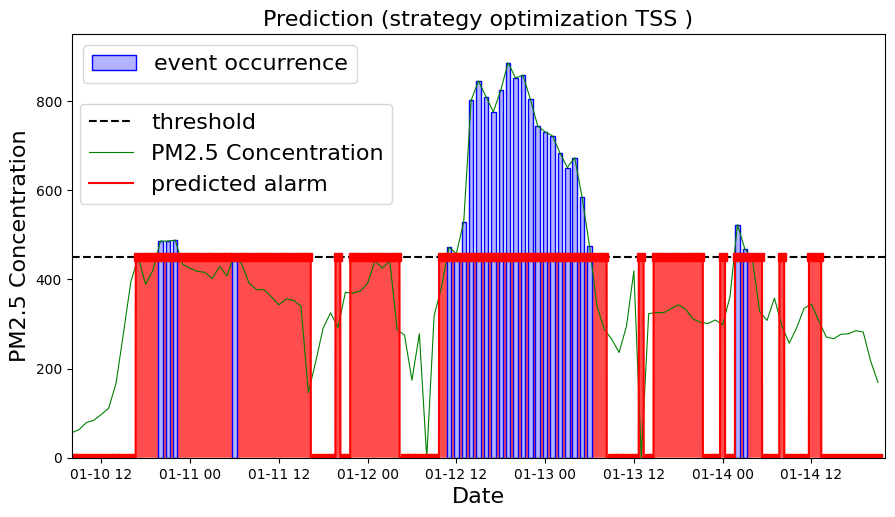

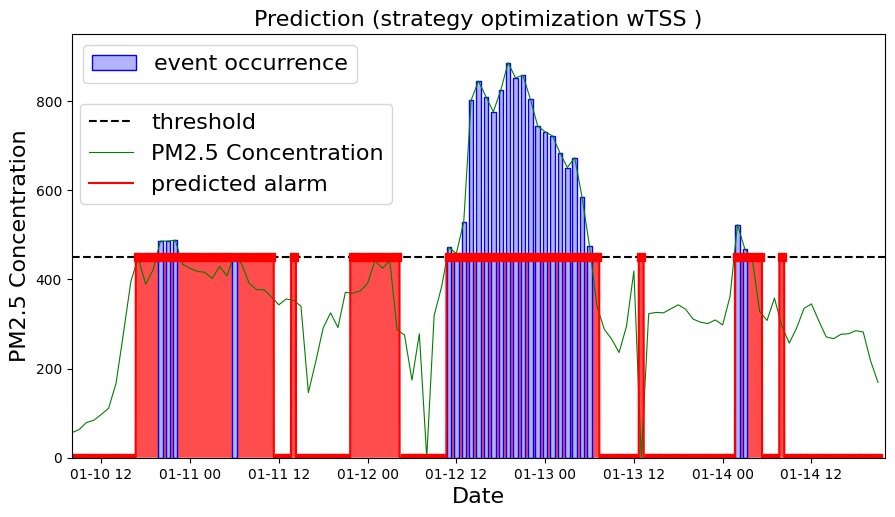

In [24]:
#figures 4 (a) (b)

import datetime as dt

dates=dataset.index[n_train_hours+n_val_hours:]
tt = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates]
import pandas as pd
folder_plot='plot_poll/'


tt1=tt[9080:9190]
poll_test_box=poll_test2[9080:9190]
idx_event_box=np.where(poll_test_box>threshold_pol)

#ensemble with TSS optimization strategy
y_pred_test_box=pred_median_pred_0_1[9080:9190]
tt1_new_arrange, y_pred_test_box_new = make_box_figure(y_pred_test_box,tt1)

tt1_idx_event = []
for i in idx_event_box[0]:
    tt1_idx_event.append(tt1[i])
    
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction (strategy optimization TSS )', fontsize=16)
plt.axhline(450,color='k',linestyle='--')
truth = ax.bar(tt1_idx_event, poll_test_box[idx_event_box], facecolor='#b3b3ff', edgecolor='blue', width=0.025,label='event occurrence')
poll = ax.plot(tt[9080:9190],poll_test2[9080:9190],color='green', linewidth=0.8) 
pred_plot = ax.plot(tt1_new_arrange, 450*(y_pred_test_box_new))
pred_plot_dots = ax.plot(tt1, 450*(pred_median_pred_0_1[9080:9190]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_box_new), facecolor='red', interpolate=True,alpha=0.7)

plt.setp(pred_plot_dots, linewidth=0.001, color='r')

max_ylim=950

ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylim(0,max_ylim)
ax.set_xlim(pd.Timestamp(2013, 1, 10, 8),pd.Timestamp(2013, 1, 14, 22))#pd.Timestamp('2013-01-07'), pd.Timestamp('2013-1-16'))
first_legend=plt.legend(handles=[truth],loc='upper left', fontsize=16)
ax.add_artist(first_legend)
ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc=(0.01,0.6),fontsize=16) #,'Event > 50 mm/h and no lamps'
fig.set_size_inches(10.5, 5.5)
model_name='lstm_1times_pred_poll_8features_train_13104_val_4320_poll_450_epoch'
#plt.savefig(folder_plot+"pred_tss_9080_9190_"+model_name+"_review.png")


#----------------------------------------------------------------------------------------------------------------------------

#ensemble with wTSS optimization strategy
y_pred_test_box=pred_median_pred_0_1_weight[9080:9190]
tt1_new_arrange, y_pred_test_box_new = make_box_figure(y_pred_test_box,tt1)

tt1_idx_event = []
for i in idx_event_box[0]:
    tt1_idx_event.append(tt1[i])
    
fig = plt.figure()
ax = fig.gca()
plt.title('Prediction (strategy optimization wTSS )', fontsize=16)

plt.axhline(450,color='k',linestyle='--')

truth = ax.bar(tt1_idx_event, poll_test_box[idx_event_box], facecolor='#b3b3ff', edgecolor='blue', width=0.025,label='event occurrence')
poll = ax.plot(tt[9080:9190],poll_test2[9080:9190],color='green', linewidth=0.8) 
pred_plot = ax.plot(tt1_new_arrange, 450*(y_pred_test_box_new))
pred_plot_dots = ax.plot(tt1, 450*(pred_median_pred_0_1_weight[9080:9190]),'s')
plt.setp(pred_plot, linewidth=1.5, color='r')
ax.fill_between(tt1_new_arrange, 0, 450*(y_pred_test_box_new), facecolor='red', interpolate=True,alpha=0.7)

plt.setp(pred_plot_dots, linewidth=0.001, color='r')

max_ylim=950

ax.xaxis_date()
ax.set_ylabel('PM2.5 Concentration', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylim(0,max_ylim)
ax.set_xlim(pd.Timestamp(2013, 1, 10, 8),pd.Timestamp(2013, 1, 14, 22))#pd.Timestamp('2013-01-07'), pd.Timestamp('2013-1-16'))
first_legend=plt.legend(handles=[truth],loc='upper left', fontsize=16)
ax.add_artist(first_legend)
ax.legend(['threshold','PM2.5 Concentration','predicted alarm'],loc=(0.01,0.6),fontsize=16) #,'Event > 50 mm/h and no lamps'
fig.set_size_inches(10.5, 5.5)
model_name='lstm_1times_pred_poll_8features_train_13104_val_4320_poll_450_epoch'
#plt.savefig(folder_plot+"pred_wtss_9080_9190_"+model_name+"_review.png")



# Early stopping experiments

In [25]:
# Model and fit for early stopping experiments

if run == True:
    folder_path = 'prediction/'
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.summary()
    # choose the patience (experiments with patience 10,20,30,40,50)
    patience=40
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',\
                            patience=patience,mode='min')

    model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(val_X, val_y),
                        callbacks=[callback],verbose=2, shuffle=False)
    ep = len(model.history.history['loss'])
    print('epochs:',ep)
    # plot history
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
    if save == True:
        model.save_weights(folder_path+'early_stop'+str(patience)+'_lstm_1times_pred_poll_8features_train_13104_val_4320_poll_450_epoch.hdf5')

In [26]:
#Load models obtained by applying early stopping with 5 different patiences (10,20,30,40,50)
#For each model compute the best thresholds by optimizing TSS and wTSS
# Choose models with the highest TSS and the highest wTSS in validation
folder_path='prediction/'

tss_opt_tss,wtss_opt_wtss, threshold_opt_tss, threshold_opt_wtss = select_best_patience_on_val(folder_path,train_X,train_y, val_X, val_y)

    
idx_patience_tss = numpy.argmax(tss_opt_tss)
idx_patience_wtss = numpy.argmax(wtss_opt_wtss)

idx best nss= (array([46]),)
best NSS
confusion matrix
[[12928, 69], [15, 92]]
false alarm ratio       	 0.42857142857142855
probability of detection	 0.8598130841121495
accuracy                	 0.9935897435897436
hss                     	 0.6834616948552058
tss                     	 0.8545041666696628
balance                 	 0.21739130434782608
csi                 	 0.5227272727272727
idx best tss= (array([3]),)
best TSS
confusion matrix
[[12678, 319], [3, 104]]
false alarm ratio       	 0.7541371158392435
probability of detection	 0.9719626168224299
accuracy                	 0.9754273504273504
hss                     	 0.38442954641541344
tss                     	 0.9474184912549912
balance                 	 0.009404388714733543
csi                 	 0.24413145539906103
idx best hss= (array([68]),)
best HSS
confusion matrix
[[12978, 19], [32, 75]]
false alarm ratio       	 0.20212765957446807
probability of detection	 0.7009345794392523
accuracy                	 0.9961080586080586

MAX TSS: 0.9242760845909187
MAX HSS: 0.7686090869593682
idx best nss= (array([18]),)
best NSS
confusion matrix
[[12953.            45.66666667]
 [   15.33333333    89.        ]]
false alarm ratio       	 0.33910891089108913
probability of detection	 0.8530351437699681
accuracy                	 0.9953445775776539
hss                     	 0.7424589217772284
tss                     	 0.8495219629309078
balance                 	 0.33576642335766427
csi                 	 0.5933333333333334
idx best tss= (array([3]),)
best TSS
confusion matrix
[[1.27560000e+04 3.85083333e+02]
 [4.91666667e+00 1.01000000e+02]]
false alarm ratio       	 0.7922166980970342
probability of detection	 0.9535798583792289
accuracy                	 0.9705593719332679
hss                     	 0.33245128010225133
tss                     	 0.9242760845909187
balance                 	 0.012767799177667169
csi                 	 0.2057026476578411
idx best hss= (array([57]),)
best HSS
confusion matrix
[[12976.           

In [27]:

#---------------------------------------------------------------------------------------------------
# predict with the tss optimization strategy
y_pred_test = predict(folder_path,train_X.shape[1],train_X.shape[2],idx_patience_tss,Xtest2,threshold_opt_tss)

cm_test, tss_test, hss_test, csi_test = compute_cm_tss(ytest2, y_pred_test)#_weight
print('Skill scores (optimization tss)')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))
wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(ytest2, y_pred_test)#_weight
print('Weighted Skill scores (optimization tss)')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))

#---------------------------------------------------------------------------------------------------
# predict with the wtss optimization strategy
y_pred_test_weight = predict(folder_path,train_X.shape[1],train_X.shape[2],idx_patience_wtss,Xtest2,threshold_opt_wtss)


cm_test, tss_test, hss_test, csi_test = compute_cm_tss(ytest2, y_pred_test_weight)#_weight
print('Skill scores (optimization wtss)')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))
wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(ytest2, y_pred_test_weight)#_weight
print('Weighted Skill scores (optimization wtss)')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))

Skill scores (optimization tss)
[[25831   396]
 [    5   143]]
tss =  0.9511
hss =  0.4111
csi =  0.2629
Weighted Skill scores (optimization tss)
[[2.58310000e+04 6.41416667e+02]
 [4.50000000e+00 1.43000000e+02]]
wtss =  0.9453
whss =  0.3004
wcsi =  0.1813
Skill scores (optimization wtss)
[[25831   396]
 [    5   143]]
tss =  0.9511
hss =  0.4111
csi =  0.2629
Weighted Skill scores (optimization wtss)
[[2.58310000e+04 6.41416667e+02]
 [4.50000000e+00 1.43000000e+02]]
wtss =  0.9453
whss =  0.3004
wcsi =  0.1813
